#  Image Convolution

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-+-Images" data-toc-modified-id="Imports-+-Images-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports + Images</a></span></li><li><span><a href="#Converting-JPGs-to-Fits-Files" data-toc-modified-id="Converting-JPGs-to-Fits-Files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Converting JPGs to Fits Files</a></span></li><li><span><a href="#Convolve-Image" data-toc-modified-id="Convolve-Image-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convolve Image</a></span></li></ul></div>

## Imports + Images

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from astropy.io import fits
from astropy import units as u
import scipy
from skimage import color
from skimage import exposure
import seaborn as sns
sns.set()

In [13]:
from astropy.table import Table as t
darg_mergers = t.read('Catalogs/darg_mergers.fits')

In [1]:
import glob
merger_cutouts_256 = glob.glob('Cutouts/Color/256/Mergers/*.jpeg')

## Converting JPGs to Fits Files

Assuming scale is 128 pixels = 50.6" 

In [69]:
def file_to_fits_mergers(filename):
    img = io.imread(filename, as_gray = True)
    dimx, dimy = len(img[0]), len(img[:,0])
    
    cat_index = int(filename.split('Mergers/')[-1].split('.jpeg')[0])-1
    ra1, dec1, ra2, dec2, z1, z2 = darg_mergers[cat_index]['ra1', 'dec1', 'ra2', 'dec2', 'specz1', 'specz2']
    
    hdu = fits.PrimaryHDU(img)
    hdul = fits.HDUList([hdu])
    hdr = hdul[0].header
    
    hdr['ra1'] = ra1
    hdr['dec1'] = dec1
    hdr['ra2'] = ra2
    hdr['dec2'] = dec2
    hdr['z1'] = z1
    hdr['z2'] = z2
    hdr['xlength'] = (dimx/128) * 50.6 
    hdr['ylength'] = (dimy/128) * 50.6 
    hdr['units'] = 'arcsec'
    
    return hdul

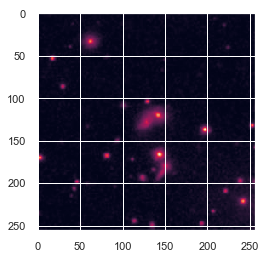

In [84]:
hdul = file_to_fits_mergers(merger_cutouts_256[0])
plt.imshow(hdul[0].data)
plt.show()

## Convolve Image

Below is a written out 2d convolution function. We'll likely be using scipy's version but here's the math so we know what's going on.

Convolve2d_math and other code comes from [here](http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html)

In [78]:
def convolve2d_math(image, kernel):
    # This function which takes an image and a kernel 
    # and returns the convolution of them
    # Args:
    #   image: a numpy array of size [image_height, image_width].
    #   kernel: a numpy array of size [kernel_height, kernel_width].
    # Returns:
    #   a numpy array of size [image_height, image_width] (convolution output).
    
    kernel = np.flipud(np.fliplr(kernel))    # Flip the kernel
    output = np.zeros_like(image)            # convolution output
    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))   
    image_padded[1:-1, 1:-1] = image
    for x in range(image.shape[1]):     # Loop over every pixel of the image
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            output[y,x]=(kernel*image_padded[y:y+3,x:x+3]).sum()        
    return output

In [94]:
def convolve_image(hdul, kernel, scale = True):
    img = hdul[0].data
    # you can use 'valid' instead of 'same', then it will not add zero padding
    final_image = scipy.signal.convolve2d(img, kernel, 'same')

    if scale:
        # Adjust the contrast of the filtered image by applying Histogram Equalization 
        final_image = exposure.equalize_adapthist(final_image/np.max(np.abs(final_image)), clip_limit=0.03)
    
    plt.figure(dpi=100)
    plt.imshow(final_image, cmap=plt.cm.gray)
    plt.show()
    
    return final_image

The following image convolution kernels come from [here](https://en.wikipedia.org/wiki/Kernel_(image_processing))

In [92]:
identify_kernel = np.array([[0,0,0],[0,1,0],[0,0,0]])
edge_detection_kernel1 = np.array([[1,0,-1],[0,0,0],[-1,0,1]])
edge_detection_kernel2 = np.array([[0,1,0],[1,-4,1],[0,1,0]])
edge_detection_kernel3 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
sharpen_kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
box_blur_kernel = (1/9)*np.array([[1,1,1],[1,1,1],[1,1,1]])
gaussian_blur_kernel = (1/16)*np.array([[1,2,1],[2,4,2],[1,2,1]])

all_kernels = np.array([identify_kernel, edge_detection_kernel1, edge_detection_kernel2, edge_detection_kernel3, 
                       sharpen_kernel, box_blur_kernel, gaussian_blur_kernel])

Original Image


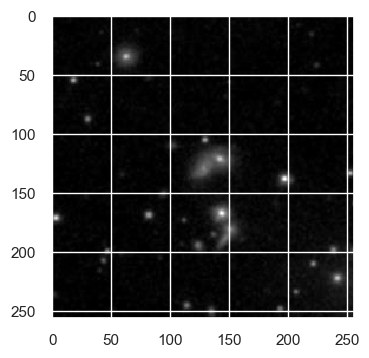

Kernel:  Identify


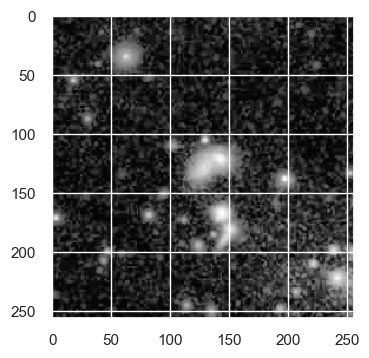

Kernel:  Edge Detection 1


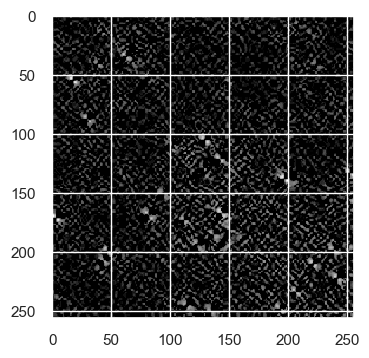

Kernel:  Edge Detection 2


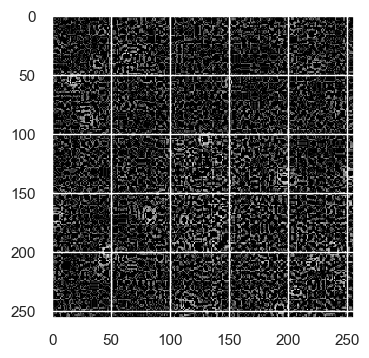

Kernel:  Edge Detection 3


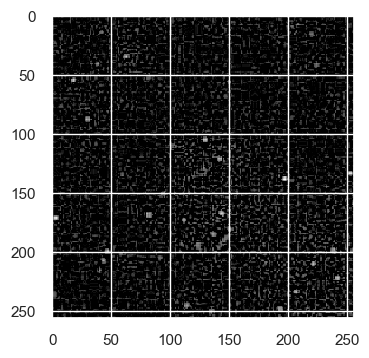

Kernel:  Sharpen


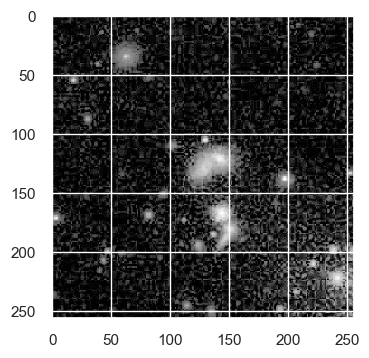

Kernel:  Box Blur


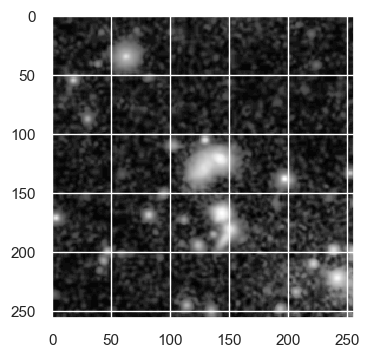

Kernel:  Gaussian Blur


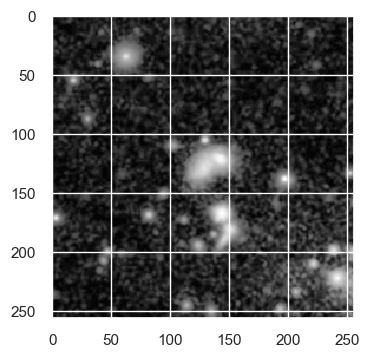

In [96]:
kernel_names = ['Identify', 'Edge Detection 1', 'Edge Detection 2', 'Edge Detection 3', 
                'Sharpen', 'Box Blur', 'Gaussian Blur']
print('Original Image')
plt.figure(dpi=100)
plt.imshow(hdul[0].data, cmap=plt.cm.gray)
plt.show()

for ak, kn in zip(all_kernels, kernel_names):
    print('Kernel: ', kn)
    eat_output = convolve_image(hdul, ak, scale = True)